# Projet: Walmart Sales

> Le service marketing de Walmart nous a demand√© de construire un mod√®le de machine learning capable d'**estimer les ventes hebdomadaires** dans leurs magasins, avec la meilleure pr√©cision possible sur les pr√©dictions faites. Un tel mod√®le les aiderait √† mieux comprendre comment les ventes sont influenc√©es par les indicateurs √©conomiques, et pourrait √™tre utilis√© pour planifier de futures campagnes marketing.


## Import des modules

In [495]:
import pandas as pd
import numpy as np

from summarytools import dfSummary

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns


## Part 1 : Exploration des donn√©es (EDA)

### Chargement & aper√ßu du dataset

In [496]:
sales_df = pd.read_csv("./data/Walmart_Store_sales.csv")
display(sales_df.head(15))

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0     6.0  18-02-2011    1572117.54           NaN        59.61       3.045   
1    13.0  25-03-2011    1807545.43           0.0        42.38       3.435   
2    17.0  27-07-2012           NaN           0.0          NaN         NaN   
3    11.0         NaN    1244390.03           0.0        84.57         NaN   
4     6.0  28-05-2010    1644470.66           0.0        78.89       2.759   
5     4.0  28-05-2010    1857533.70           0.0          NaN       2.756   
6    15.0  03-06-2011     695396.19           0.0        69.80       4.069   
7    20.0  03-02-2012    2203523.20           0.0        39.93       3.617   
8    14.0  10-12-2010    2600519.26           0.0        30.54       3.109   
9     3.0         NaN     418925.47           0.0        60.12       3.555   
10    8.0  19-08-2011     895066.50           0.0        82.92       3.554   
11   18.0  15-10-2010    1029618.10           0.0        52.02       2.878   
12    7.0  13-05-2011     414094.05           0.0        36.61       3.767   
13    1.0  16-03-2012    1677472.78           0.0        64.74       3.734   
14   17.0  01-10-2010     829207.27           0.0        60.07       2.853   

           CPI  Unemployment  
0   214.777523         6.858  
1   128.616064         7.470  
2   130.719581         5.936  
3   214.556497         7.346  
4   212.412888         7.092  
5   126.160226         7.896  
6   134.855161         7.658  
7   213.023622         6.961  
8          NaN           NaN  
9   224.132020         6.833  
10  219.070197         6.425  
11  132.763355         9.331  
12  192.826069         8.595  
13  221.211813         7.348  
14  126.234600         6.885

In [497]:
dfSummary(sales_df)


L'objectif est de pr√©dire les ventes hebdomadaires `Weekly_Sales`. 14 valeurs manquantes dont les lignes seront supprim√©es.

C'est un ***petit*** dataset! 150 lignes seulement. Avec des donn√©es concernant 20 magasins.

| Colonne | Type | Description |
| - | - | - |
| Store | num | ID du magasin |
| Date | date (as string) |  date de la semaine de vente |
| Weekly_Sales | num |  volume de vente hebdomadaire |
| Holiday_Flag | bool |  p√©riode de vacances |
| Temperature | num |  temp√©rature du jour (donne une id√©e grossi√®re du temps) |
| Fuel_Price | num |  prix de l'essence dans la r√©gion du magasin |
| CPI | num |  indice des prix √† la consommation (apr√©s analyse, sp√©cifique √† chaque magasin)
| Unemployment | num |  taux de ch√¥mage |


In [498]:
# Typage des colonnes
sales_df["Date"] = pd.to_datetime(sales_df['Date'], format='%d-%m-%Y')
sales_df["Holiday_Flag"] = sales_df["Holiday_Flag"].astype('bool')

sales_df["Store"] = sales_df["Store"].astype('int')

In [499]:
sales_df.dtypes

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag              bool
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object

### Elimination des lignes invalide ou doubles

In [500]:
# Pas de target => inexploitable
sales_df = sales_df.dropna(subset=["Weekly_Sales"])

# Pas de date => on pourra rien en faire √† priori !
sales_df = sales_df.dropna(subset=["Date"])

print("New shape: ", sales_df.shape)

New shape:  (118, 8)


In [501]:
# Supprimer les doublons exacts s‚Äôil y en a
sales_df.drop_duplicates(inplace=True)
print("New shape: ", sales_df.shape)

New shape:  (118, 8)


### Feature engineering: d√©composition de la date

In [502]:
# D√©composition de la date
sales_df["Date"] = pd.to_datetime(sales_df["Date"], format="%d-%m-%Y")

sales_df["Year"] = sales_df["Date"].dt.year
sales_df["Month"] = sales_df["Date"].dt.month
sales_df["Week"] = sales_df["Date"].dt.isocalendar().week
sales_df["Day"] = sales_df["Date"].dt.day
sales_df["DayOfWeek"] = sales_df["Date"].dt.dayofweek

date_columns = ["Year", "Month", "Week", "Day", "DayOfWeek"]

# Enforce int type
sales_df[date_columns] = sales_df[date_columns].convert_dtypes()

sales_df

Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0        6 2011-02-18    1572117.54          True        59.61       3.045   
1       13 2011-03-25    1807545.43         False        42.38       3.435   
4        6 2010-05-28    1644470.66         False        78.89       2.759   
5        4 2010-05-28    1857533.70         False          NaN       2.756   
6       15 2011-06-03     695396.19         False        69.80       4.069   
..     ...        ...           ...           ...          ...         ...   
144      3 2012-10-19     424513.08         False        73.44       3.594   
145     14 2010-06-18    2248645.59         False        72.62       2.780   
147     17 2010-06-11     845252.21         False        57.14       2.841   
148      8 2011-08-12     856796.10         False        86.05       3.638   
149     19 2012-04-20    1255087.26         False        55.20       4.170   

            CPI  Unemployment  Year  Month  Week  Day  DayOfWeek  
0    214.777523         6.858  2011      2     7   18          4  
1    128.616064         7.470  2011      3    12   25          4  
4    212.412888         7.092  2010      5    21   28          4  
5    126.160226         7.896  2010      5    21   28          4  
6    134.855161         7.658  2011      6    22    3          4  
..          ...           ...   ...    ...   ...  ...        ...  
144  226.968844         6.034  2012     10    42   19          4  
145  182.442420         8.899  2010      6    24   18          4  
147  126.111903           NaN  2010      6    23   11          4  
148  219.007525           NaN  2011      8    32   12          4  
149  137.923067         8.150  2012      4    16   20          4  

[118 rows x 13 columns]

In [503]:
sales_df.dtypes

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag              bool
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
Year                     Int32
Month                    Int32
Week                    UInt32
Day                      Int32
DayOfWeek                Int32
dtype: object

### Data viz

In [504]:
numerical_cols = ["Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment"]
categorical_cols = ["Store", "Holiday_Flag", "Year", "Month", "Week", "Day", "DayOfWeek"]


In [505]:
# Statistiques descriptives
sales_df.describe()


Store                           Date  Weekly_Sales  Temperature  \
count  118.000000                            118  1.180000e+02   107.000000   
mean     9.949153  2011-04-23 04:28:28.474576384  1.257271e+06    60.711589   
min      1.000000            2010-02-05 00:00:00  2.689290e+05    18.790000   
25%      4.250000            2010-07-30 00:00:00  5.774276e+05    45.465000   
50%      9.000000            2011-04-29 00:00:00  1.331001e+06    61.790000   
75%     15.000000            2011-12-31 18:00:00  1.810591e+06    75.430000   
max     20.000000            2012-10-19 00:00:00  2.771397e+06    91.650000   
std      6.066367                            NaN  6.625056e+05    17.961676   

       Fuel_Price         CPI  Unemployment         Year     Month       Week  \
count  107.000000  109.000000    107.000000        118.0     118.0      118.0   
mean     3.291542  177.718009      7.681299  2010.822034  6.338983  25.423729   
min      2.514000  126.111903      5.143000       2010.0       1.0        1.0   
25%      2.824000  131.637000      6.664000       2010.0       4.0      15.25   
50%      3.308000  194.379637      7.484000       2011.0       6.0       25.0   
75%      3.691500  214.777523      8.150000      2011.75       9.0       36.0   
max      4.193000  226.968844     14.313000       2012.0      12.0       52.0   
std      0.486784   39.816657      1.678155     0.812628  3.173664  13.783061   

             Day  DayOfWeek  
count      118.0      118.0  
mean   16.440678        4.0  
min          1.0        4.0  
25%         10.0        4.0  
50%         16.5        4.0  
75%         24.0        4.0  
max         31.0        4.0  
std     8.209378        0.0

#### Analyse univari√©e

##### Valeur cat√©gorielles

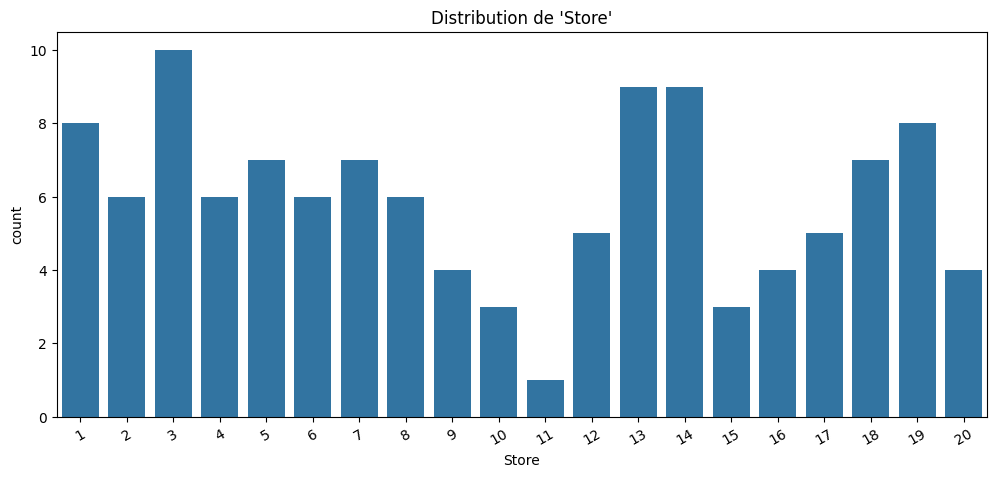

Store = 3: 8.47%
Store = 13: 7.63%
Store = 14: 7.63%
Store = 19: 6.78%
Store = 1: 6.78%
Store = 7: 5.93%
Store = 18: 5.93%
Store = 5: 5.93%
Store = 8: 5.08%
Store = 4: 5.08%
Store = 6: 5.08%
Store = 2: 5.08%
Store = 12: 4.24%
Store = 17: 4.24%
Store = 16: 3.39%
Store = 20: 3.39%
Store = 9: 3.39%
Store = 15: 2.54%
Store = 10: 2.54%
Store = 11: 0.85%


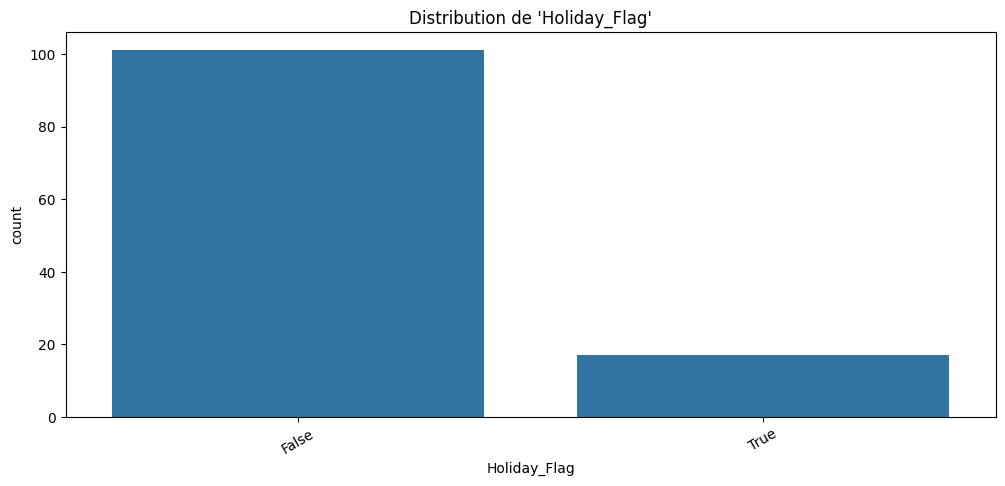

Holiday_Flag = False: 85.59%
Holiday_Flag = True: 14.41%


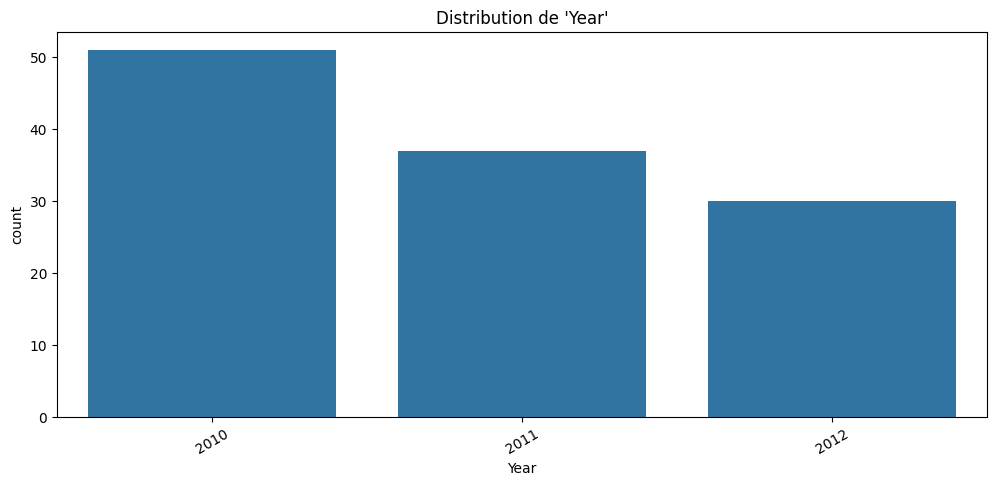

Year = 2010: 43.22%
Year = 2011: 31.36%
Year = 2012: 25.42%


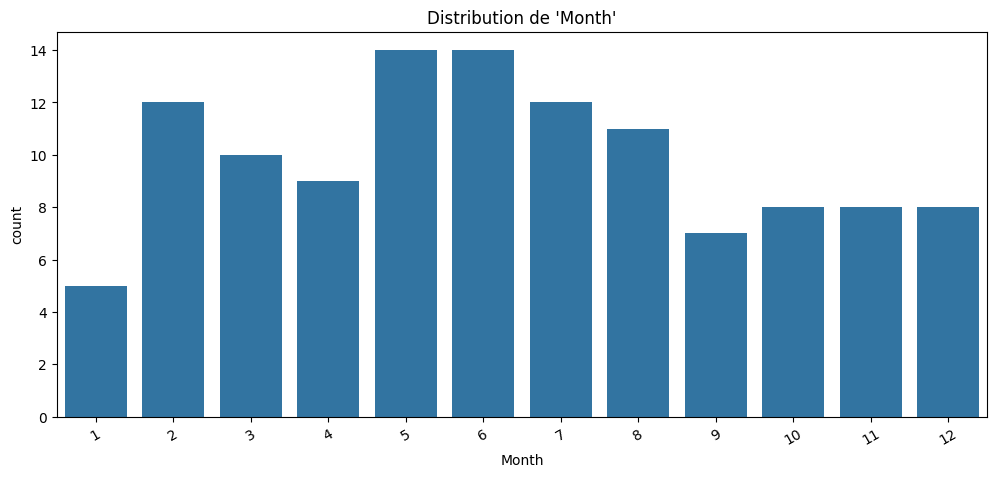

Month = 6: 11.86%
Month = 5: 11.86%
Month = 2: 10.17%
Month = 7: 10.17%
Month = 8: 9.32%
Month = 3: 8.47%
Month = 4: 7.63%
Month = 12: 6.78%
Month = 10: 6.78%
Month = 11: 6.78%
Month = 9: 5.93%
Month = 1: 4.24%


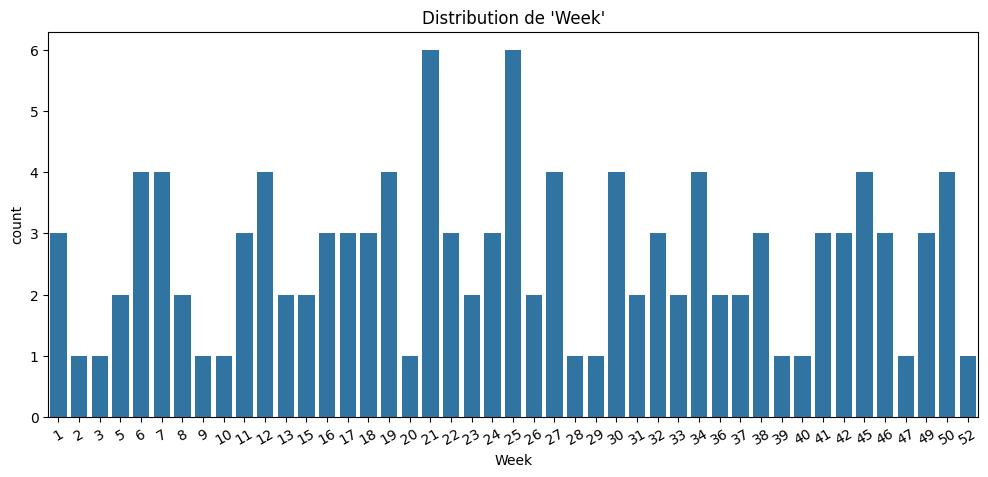

Week = 21: 5.08%
Week = 25: 5.08%
Week = 7: 3.39%
Week = 50: 3.39%
Week = 12: 3.39%
Week = 34: 3.39%
Week = 45: 3.39%
Week = 27: 3.39%
Week = 30: 3.39%
Week = 6: 3.39%
Week = 19: 3.39%
Week = 17: 2.54%
Week = 22: 2.54%
Week = 1: 2.54%
Week = 46: 2.54%
Week = 16: 2.54%
Week = 11: 2.54%
Week = 49: 2.54%
Week = 41: 2.54%
Week = 18: 2.54%
Week = 38: 2.54%
Week = 32: 2.54%
Week = 42: 2.54%
Week = 24: 2.54%
Week = 5: 1.69%
Week = 13: 1.69%
Week = 33: 1.69%
Week = 8: 1.69%
Week = 37: 1.69%
Week = 36: 1.69%
Week = 15: 1.69%
Week = 31: 1.69%
Week = 26: 1.69%
Week = 23: 1.69%
Week = 39: 0.85%
Week = 20: 0.85%
Week = 2: 0.85%
Week = 10: 0.85%
Week = 28: 0.85%
Week = 9: 0.85%
Week = 52: 0.85%
Week = 47: 0.85%
Week = 3: 0.85%
Week = 29: 0.85%
Week = 40: 0.85%


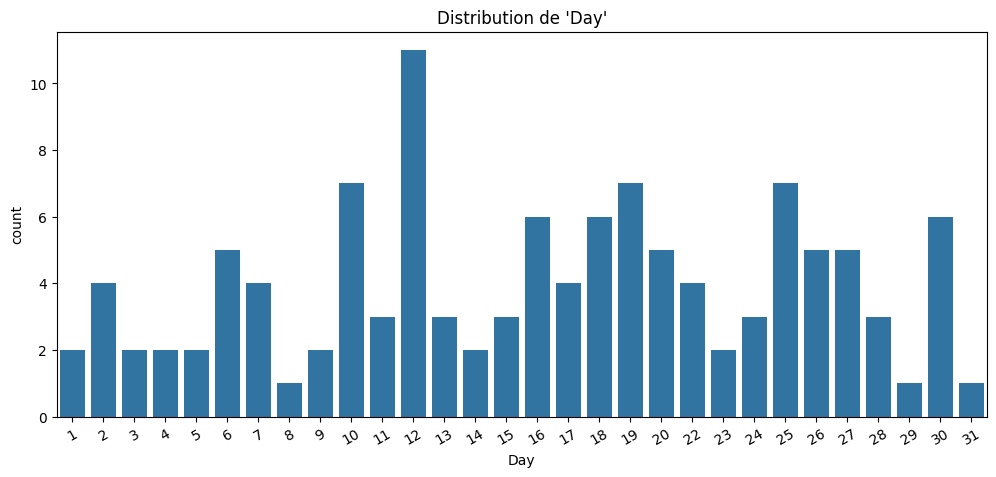

Day = 12: 9.32%
Day = 25: 5.93%
Day = 10: 5.93%
Day = 19: 5.93%
Day = 16: 5.08%
Day = 18: 5.08%
Day = 30: 5.08%
Day = 20: 4.24%
Day = 6: 4.24%
Day = 26: 4.24%
Day = 27: 4.24%
Day = 17: 3.39%
Day = 2: 3.39%
Day = 7: 3.39%
Day = 22: 3.39%
Day = 28: 2.54%
Day = 15: 2.54%
Day = 13: 2.54%
Day = 11: 2.54%
Day = 24: 2.54%
Day = 1: 1.69%
Day = 3: 1.69%
Day = 14: 1.69%
Day = 23: 1.69%
Day = 4: 1.69%
Day = 5: 1.69%
Day = 9: 1.69%
Day = 31: 0.85%
Day = 29: 0.85%
Day = 8: 0.85%


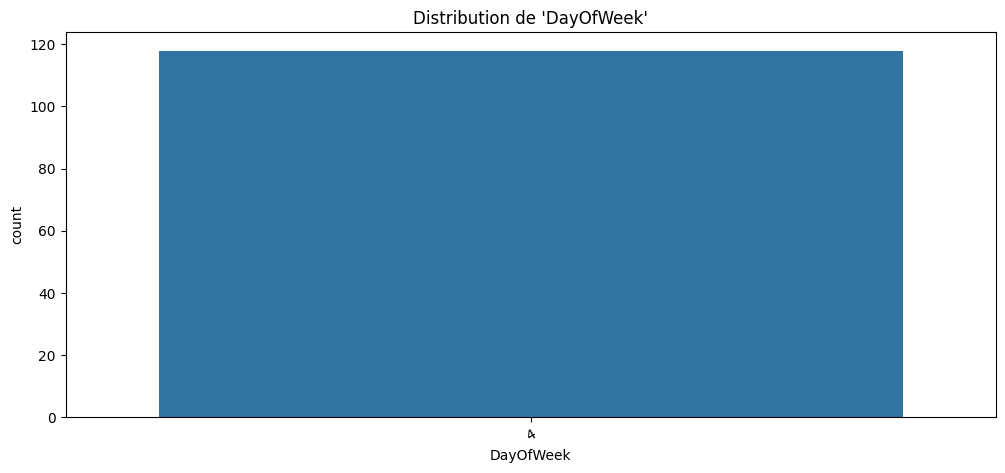

DayOfWeek = 4: 100.00%


In [506]:
for col in categorical_cols:
    plt.figure(figsize=(12, 5))
    sns.countplot(x=col, data=sales_df)
    plt.title(f"Distribution de '{col}'")
    plt.xticks(rotation=30)
    plt.show()
    
    dist = sales_df[col].value_counts(normalize=True) * 100
    for value, pct in dist.items():
        print(f"{col} = {value}: {pct:.2f}%")

##### Valeurs num√©riques

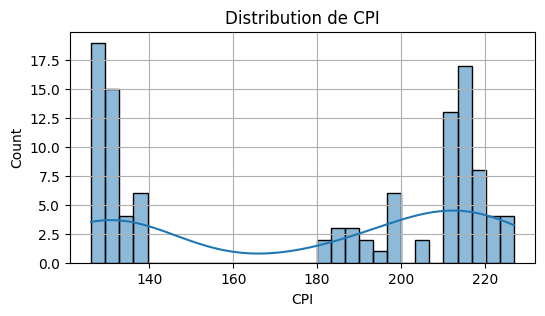

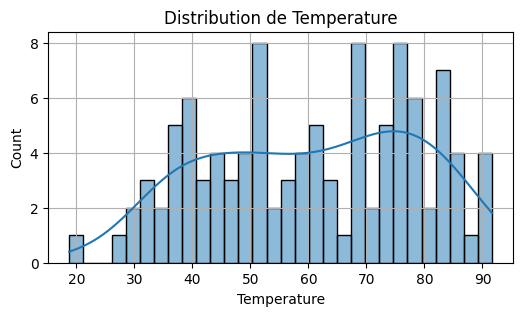

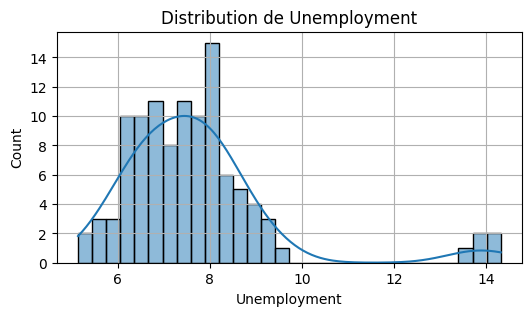

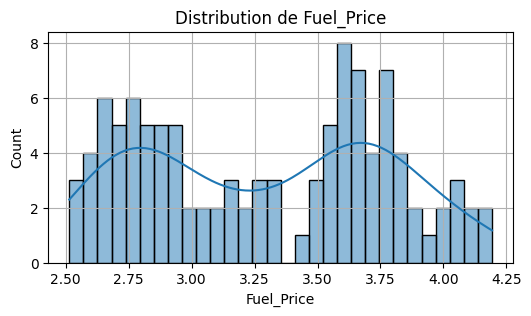

In [507]:
# Visualisation des distributions des variables ayant des valeurs nulles
for col in ["CPI", "Temperature", "Unemployment", "Fuel_Price"]:
    if sales_df[col].isnull().sum() > 0:
        plt.figure(figsize=(6, 3))
        sns.histplot(sales_df[col], kde=True, bins=30)
        plt.title(f'Distribution de {col}')
        plt.grid(True)
        plt.show()

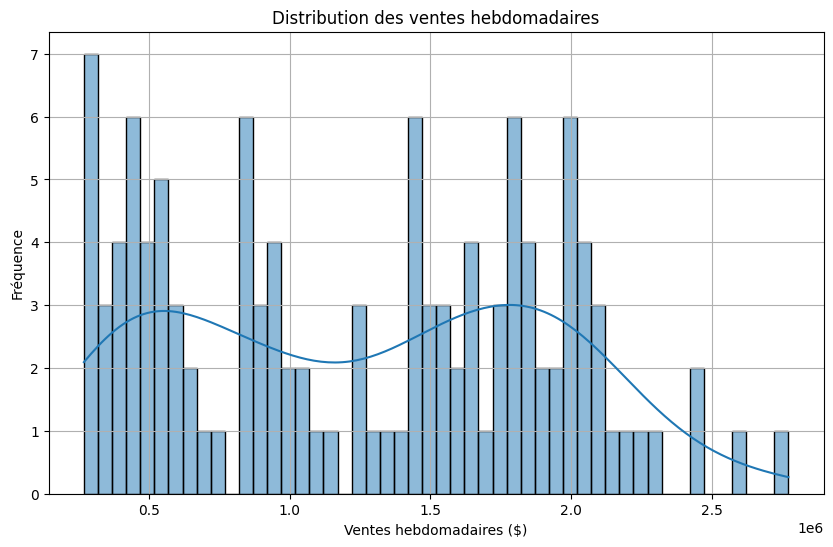

In [508]:
plt.figure(figsize=(10, 6))
sns.histplot(sales_df['Weekly_Sales'], bins=50, kde=True)
plt.title('Distribution des ventes hebdomadaires')
plt.xlabel('Ventes hebdomadaires ($)')
plt.ylabel('Fr√©quence')
plt.grid(True)
plt.show()

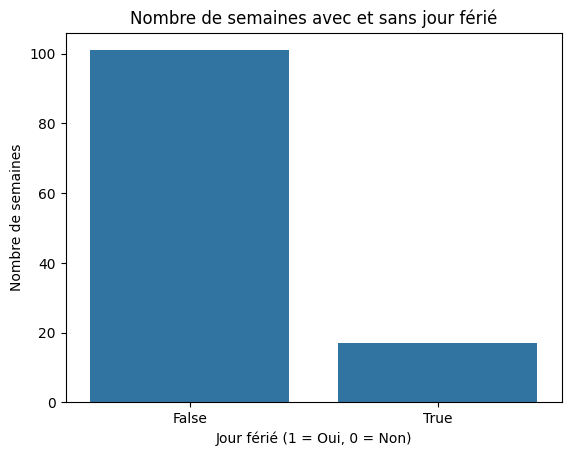

In [509]:
sns.countplot(data=sales_df, x='Holiday_Flag')
plt.title("Nombre de semaines avec et sans jour f√©ri√©")
plt.xlabel("Jour f√©ri√© (1 = Oui, 0 = Non)")
plt.ylabel("Nombre de semaines")
plt.show()

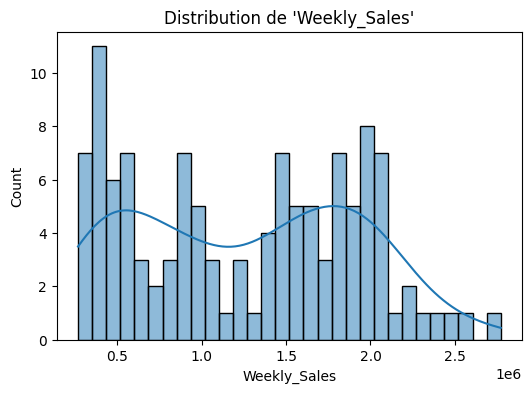

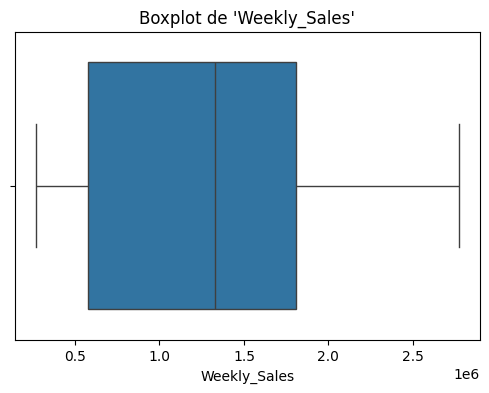

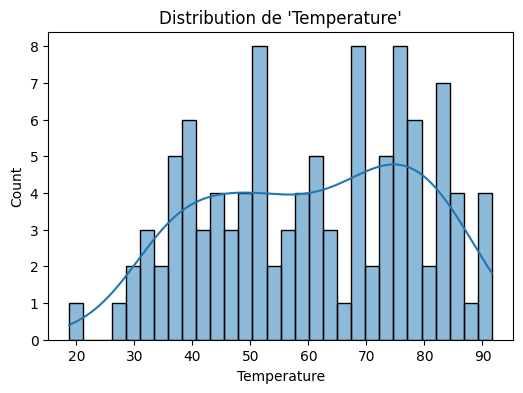

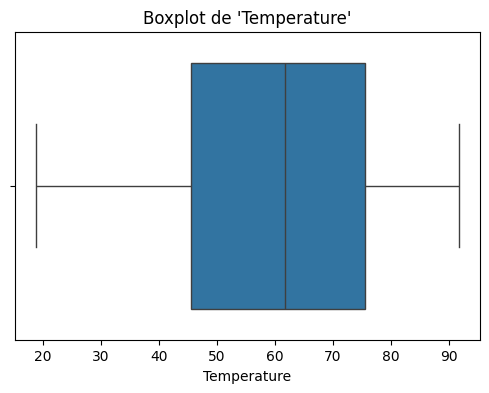

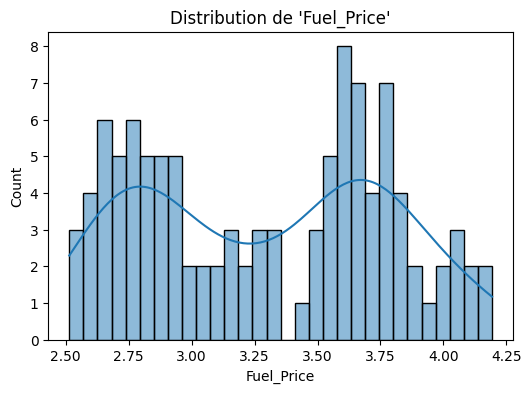

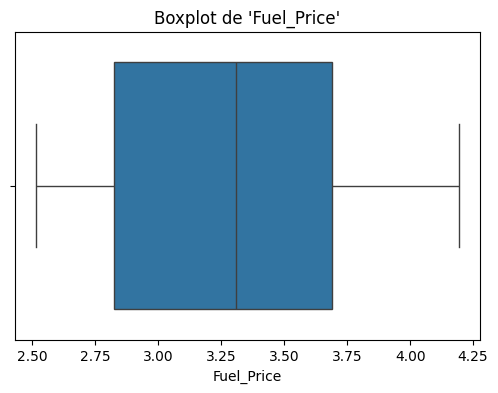

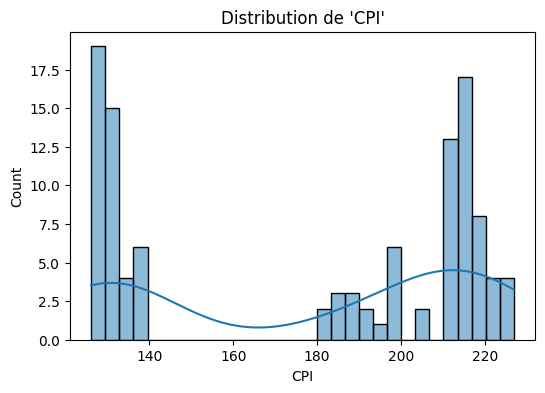

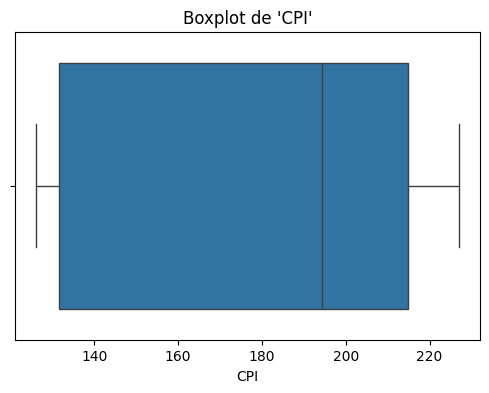

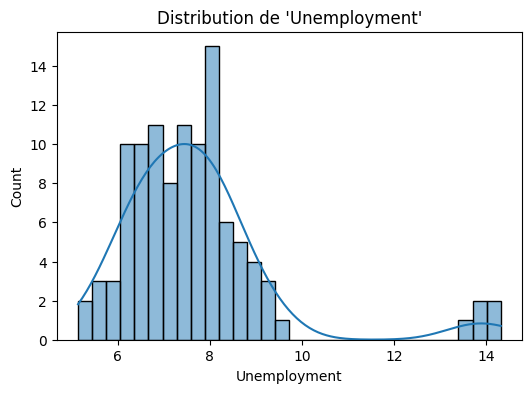

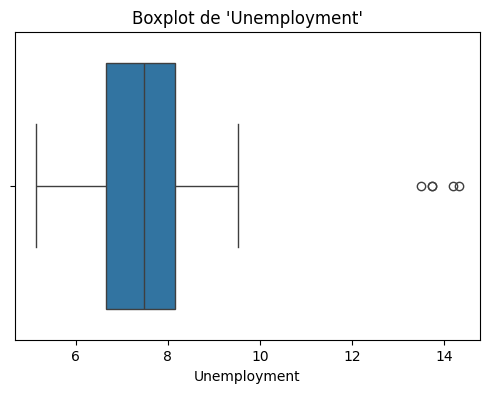

In [510]:
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(sales_df[col], kde=True, bins=30)
    plt.title(f"Distribution de '{col}'")
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.boxplot(x=sales_df[col])
    plt.title(f"Boxplot de '{col}'")
    plt.show()

#### Analyse bivari√©e

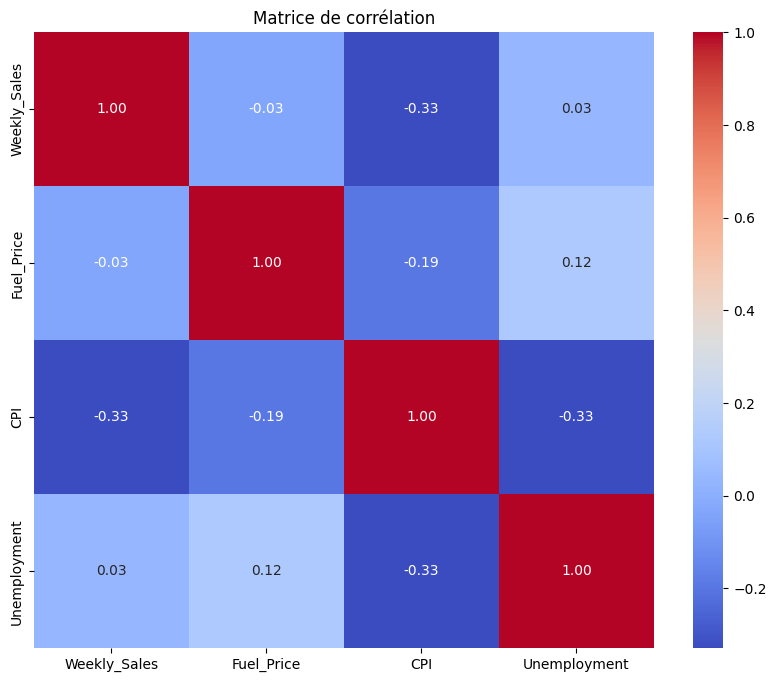

In [511]:
plt.figure(figsize=(10, 8))
corr_matrix = sales_df[['Weekly_Sales', 'Fuel_Price', 'CPI', 'Unemployment']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corr√©lation')
plt.show()

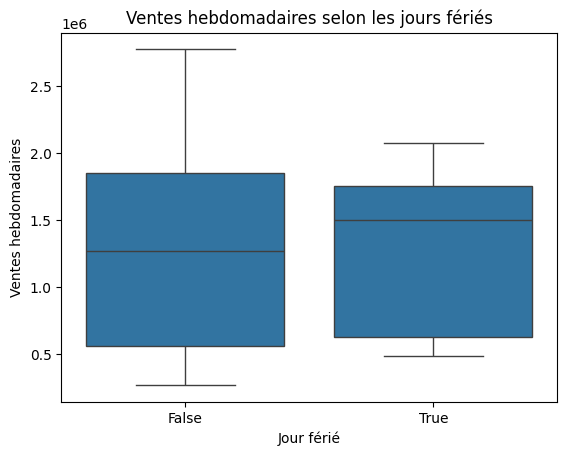

In [512]:
sns.boxplot(data=sales_df, x='Holiday_Flag', y='Weekly_Sales')
plt.title('Ventes hebdomadaires selon les jours f√©ri√©s')
plt.xlabel('Jour f√©ri√©')
plt.ylabel('Ventes hebdomadaires')
plt.show()


#### Analyse temporelle

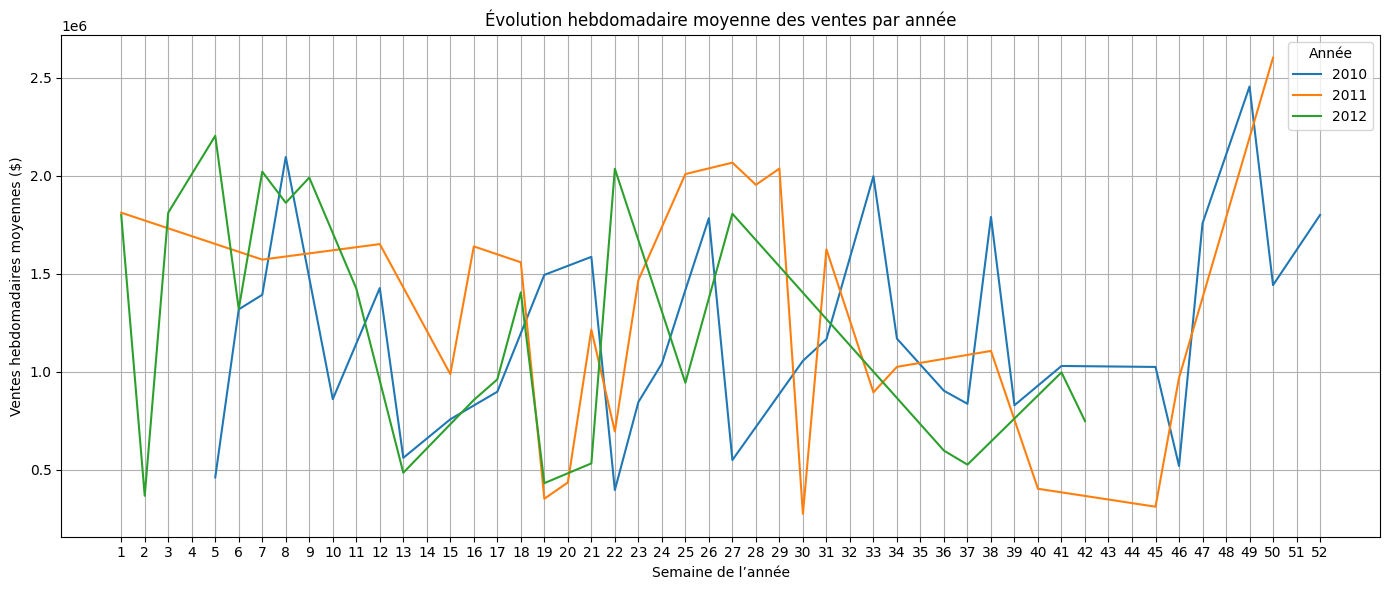

In [513]:
# moyenne des ventes par semaine et par ann√©e
weekly_sales_by_year = sales_df.groupby(['Year', 'Week'])['Weekly_Sales'].mean().reset_index()

# plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=weekly_sales_by_year, x='Week', y='Weekly_Sales', hue='Year', palette='tab10')
plt.title('√âvolution hebdomadaire moyenne des ventes par ann√©e')
plt.xlabel('Semaine de l‚Äôann√©e')
plt.ylabel('Ventes hebdomadaires moyennes ($)')
plt.xticks(range(1, 53))
plt.grid(True)
plt.legend(title='Ann√©e')
plt.tight_layout()
plt.show()


Pas assez de donn√©es pour avoir un graphe parlant √† la semaine.

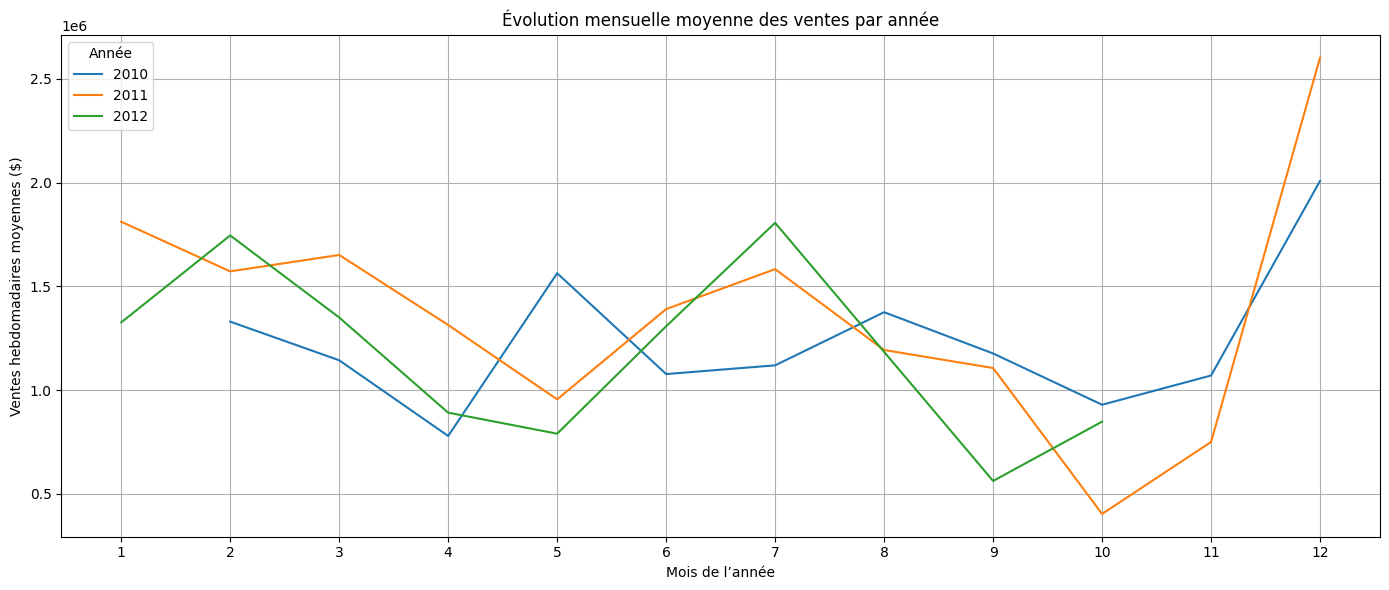

In [514]:
# moyenne des ventes par mois et par ann√©e
monthly_sales_by_year = sales_df.groupby(['Year', 'Month'])['Weekly_Sales'].mean().reset_index()

# plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_sales_by_year, x='Month', y='Weekly_Sales', hue='Year', palette='tab10')
plt.title('√âvolution mensuelle moyenne des ventes par ann√©e')
plt.xlabel('Mois de l‚Äôann√©e')
plt.ylabel('Ventes hebdomadaires moyennes ($)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend(title='Ann√©e')
plt.tight_layout()
plt.show()

L√† aussi, √ßa serait mieux avec plus de donn√©es! Mais on peut d√©j√† mieux entrevoir quelques tendances saisonni√®res.

#### Analyse par magasin

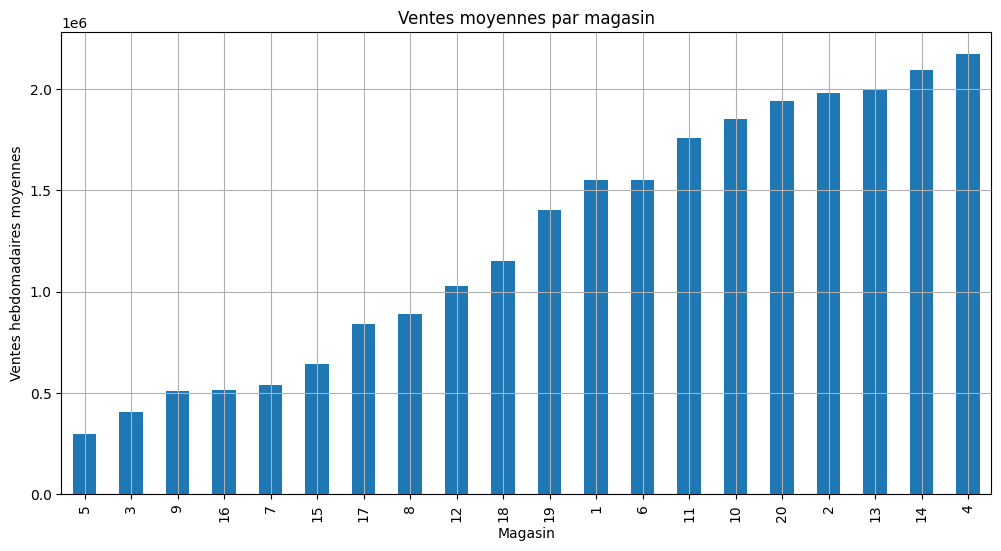

In [515]:
store_sales = sales_df.groupby('Store')['Weekly_Sales'].mean().sort_values()

plt.figure(figsize=(12, 6))
store_sales.plot(kind='bar')
plt.title('Ventes moyennes par magasin')
plt.xlabel('Magasin')
plt.ylabel('Ventes hebdomadaires moyennes')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


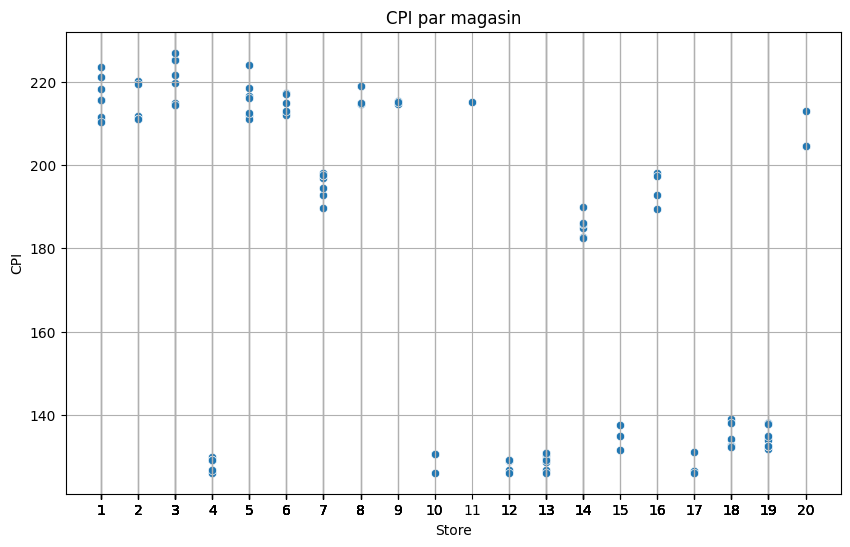

In [516]:
# CPI en fonction du magasin
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sales_df, x='Store', y='CPI')
plt.title('CPI par magasin')
plt.xlabel('Store')
plt.ylabel('CPI')
plt.xticks(sales_df['Store']) 
plt.grid(True)
plt.show()

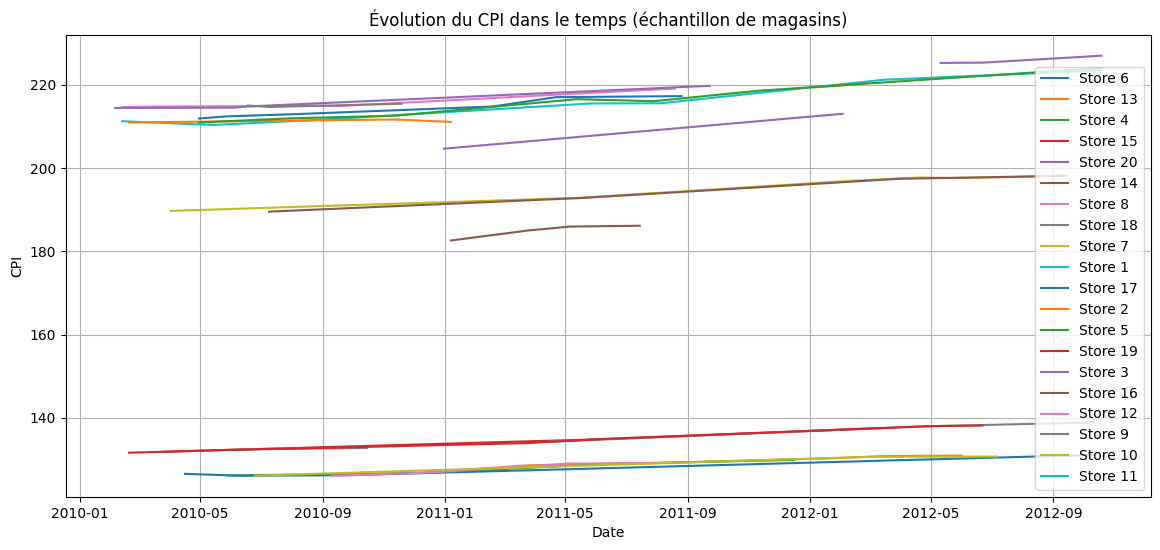

In [517]:
# S√©lection de quelques magasins
stores_sample = sales_df['Store'].unique() # [:5]

plt.figure(figsize=(14, 6))
for store in stores_sample:
    subset = sales_df[sales_df['Store'] == store]
    subset = subset.sort_values('Date')
    plt.plot(subset['Date'], subset['CPI'], label=f'Store {store}')

plt.title('√âvolution du CPI dans le temps (√©chantillon de magasins)')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.grid(True)
plt.show()


Les prix augmentent, √©videmment...

#### Synth√®se

In [518]:
holiday_means = sales_df.groupby('Holiday_Flag')['Weekly_Sales'].mean()
sell_holiday = round(holiday_means.iloc[1], 2)
sell_no_holiday = round(holiday_means.iloc[0], 2)
print("Moyenne des ventes SANS jour f√©ri√© :", sell_no_holiday)
print("Moyenne des ventes AVEC jour f√©ri√© :", sell_holiday)

ratio_no_holiday = (sell_holiday - sell_no_holiday) * 100 / sell_no_holiday

print("Le pourcentage de vente en HOLIDAY, par rapport √† NO_HOLIDAY est de :", ratio_no_holiday)

Moyenne des ventes SANS jour f√©ri√© : 1250538.3
Moyenne des ventes AVEC jour f√©ri√© : 1297272.16
Le pourcentage de vente en HOLIDAY, par rapport √† NO_HOLIDAY est de : 3.737099455490477


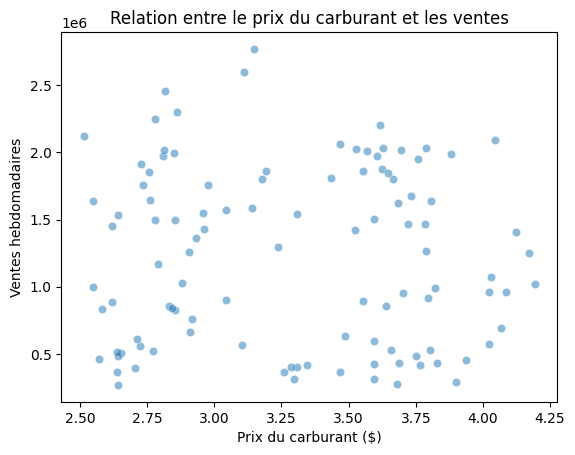

In [519]:
sns.scatterplot(data=sales_df, x='Fuel_Price', y='Weekly_Sales', alpha=0.5)
plt.title('Relation entre le prix du carburant et les ventes')
plt.xlabel('Prix du carburant ($)')
plt.ylabel('Ventes hebdomadaires')
plt.show()

- Les ventes ont une distribution tr√®s asym√©trique (forte variance entre magasins).
- L‚Äôimpact des jours f√©ri√©s semble significatif (5%).
- Des tendances temporelles (saisonnalit√©) apparaissent.
- Certaines variables √©conomiques comme le ch√¥mage ou le prix du carburant pourraient avoir une influence marginale.

- Une seule valeur pour weekday => inutile

### Outliers

La demande initiale est de supprimer toutes les lignes ayant une valeur invalide ou en dehors du range $[\bar{X} - 3\sigma, \bar{X} + 3\sigma]$ pour les valeurs num√©riques (`Temperature`, `Fuel_price`, `CPI` and `Unemployment`).

Toutefois, ayant peu de lignes, on va tenter d'en sauver quelques une, notamment en faisant de l'imputation.

In [520]:
# Unemployment et Fuel_Price ayant une correlation assez faible (peu d'influence), on va imputater par la m√©diane et garder ainsi les lignes NA.
# Done by imputer
# sales_df["Unemployment"] = sales_df["Unemployment"].fillna(sales_df["Unemployment"].median())
# sales_df["Fuel_Price"] = sales_df["Fuel_Price"].fillna(sales_df["Fuel_Price"].median())


In [521]:
# Pour les valeurs sp√©cifiques √† chaque magasin on pourrait envisager un m√©canisme similaire mais bas√© sur les valeurs de ce magasin.
# Ainsi, pour les valeurs temporelles on prendrait la moyenne des points entourant la valeur manquante.
#
# PoC
df = sales_df.sort_values(by=['Store', 'Date'])

# Fonction pour imputer les valeurs manquantes avec la moyenne des points avant et apr√®s
def impute_with_mean_before_after(group):
    group = group.copy()  # Travailler sur une copie pour √©viter de modifier les colonnes de regroupement
    for i in range(len(group)):
        if pd.isna(group['CPI'].iloc[i]):
            if i > 0 and i < len(group) - 1:
                # Calculer la moyenne des points avant et apr√®s
                mean_value = (group['CPI'].iloc[i-1] + group['CPI'].iloc[i+1]) / 2
                group.loc[group.index[i], 'CPI'] = mean_value
            elif i == 0 and i < len(group) - 1:
                # Si c'est le premier point, utiliser le point apr√®s
                group.loc[group.index[i], 'CPI'] = group['CPI'].iloc[i+1]
            elif i > 0 and i == len(group) - 1:
                # Si c'est le dernier point, utiliser le point avant
                group.loc[group.index[i], 'CPI'] = group['CPI'].iloc[i-1]
    return group

# Appliquer la fonction √† chaque groupe de magasins
df["CPI"] = df.groupby("Store", group_keys=False)[["CPI"]].apply(impute_with_mean_before_after)

display(df)

Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
44       1 2010-02-12    1641957.44          True        38.51       2.548   
95       1 2010-05-14    1494251.50         False        74.78       2.854   
73       1 2010-08-27    1449142.92          True        85.22       2.619   
123      1 2011-05-27    1466046.67         False          NaN       3.786   
48       1 2011-08-05    1624383.75          True        91.65       3.684   
..     ...        ...           ...           ...          ...         ...   
111     19 2012-06-22    1468350.36         False          NaN       3.722   
75      20 2010-06-25    1973135.87         False        75.17       2.808   
79      20 2010-09-24    1789687.65         False        69.37         NaN   
110     20 2010-12-31    1799737.79          True        28.85       3.179   
7       20 2012-02-03    2203523.20         False        39.93       3.617   

            CPI  Unemployment  Year  Month  Week  Day  DayOfWeek  
44   211.242170         8.106  2010      2     6   12          4  
95   210.337426         7.808  2010      5    19   14          4  
73   211.567306         7.787  2010      8    34   27          4  
123  215.503788         7.682  2011      5    21   27          4  
48   215.544618         7.962  2011      8    31    5          4  
..          ...           ...   ...    ...   ...  ...        ...  
111  138.162900         8.150  2012      6    25   22          4  
75   204.567546         7.856  2010      6    25   25          4  
79   204.605386         7.527  2010      9    38   24          4  
110  204.643227         7.484  2010     12    52   31          4  
7    213.023622         6.961  2012      2     5    3          4  

[118 rows x 13 columns]

<span style="color:red">Non appliqu√©</span> : le nombre de points disponible semble trop faible, pour que cette m√©thode ai du sens.

In [522]:
outliers_df = sales_df.copy()

# Suppression des lignes contenant des valeurs invalides ou des valeurs aberrantes pour les colonnes :   
for col in ["Temperature", "Fuel_Price", "CPI", "Unemployment"]:
    col_std = outliers_df[col].std()
    col_mean = outliers_df[col].mean()
    min_range = col_mean - 3 * col_std
    max_range = col_mean + 3 * col_std
    outliers_df = outliers_df.drop(outliers_df.loc[(outliers_df[col] < min_range) | (outliers_df[col] > max_range)].index, axis=0)

print("Shape            : ", sales_df.shape)
print("Without outliers : ", outliers_df.shape)

sales_df = outliers_df
# Use SimpleImputer
# na_df = outliers_df.dropna()
# print("Without NA       : ", na_df.shape)
# sales_df = na_df

Shape            :  (118, 13)
Without outliers :  (113, 13)


Encore des pertes...

A tester un simple remplacement ?
```python
print("Shape : avant", sales_df.shape)
for col in ["Temperature", "Unemployment", "Weekly_Sales", "Fuel_Price", "CPI"] :
    col_std = sales_df[col].std()
    col_mean = sales_df[col].mean()
    min_range = col_mean - 3 * col_std
    max_range = col_mean + 3 * col_std

    subst_val = sales_df[col].median() # ou mean() mais vu les distribution non gaussienne median est recommand√©.

    sales_df[col] = sales_df[col].apply(lambda x : subst_val if x < min_range or x > max_range else x)
    
print("Shape : apr√®s", sales_df.shape)
```

## Part 2 : Entainement d'un mod√®le linaire (baseline)

### Pr√©processing Pipeline

In [523]:
target_feature = "Weekly_Sales"

numerical_features = ["CPI", "Temperature", "Unemployment", "Fuel_Price"]

# We just keep month and week as temporal indicators, due to cyclic pattern
categorical_features = ["Store", "Holiday_Flag", "Month", "Week"]

# Imputer:
# - mean si distribution sym√©trique (gaussienne)
# - median si distribution asym√©trique (avec outliers)
# On n'a pas de vrai gaussienne dans nos valeurs num√©riques.
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by median
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')) # first column will be dropped to avoid creating correlations between features
])

col_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

col_preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['CPI', 'Temperature', 'Unemployment',
                                  'Fuel_Price']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Store', 'Holiday_Flag', 'Month', 'Week'])])

In [524]:
sales_df

Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0        6 2011-02-18    1572117.54          True        59.61       3.045   
1       13 2011-03-25    1807545.43         False        42.38       3.435   
4        6 2010-05-28    1644470.66         False        78.89       2.759   
5        4 2010-05-28    1857533.70         False          NaN       2.756   
6       15 2011-06-03     695396.19         False        69.80       4.069   
..     ...        ...           ...           ...          ...         ...   
144      3 2012-10-19     424513.08         False        73.44       3.594   
145     14 2010-06-18    2248645.59         False        72.62       2.780   
147     17 2010-06-11     845252.21         False        57.14       2.841   
148      8 2011-08-12     856796.10         False        86.05       3.638   
149     19 2012-04-20    1255087.26         False        55.20       4.170   

            CPI  Unemployment  Year  Month  Week  Day  DayOfWeek  
0    214.777523         6.858  2011      2     7   18          4  
1    128.616064         7.470  2011      3    12   25          4  
4    212.412888         7.092  2010      5    21   28          4  
5    126.160226         7.896  2010      5    21   28          4  
6    134.855161         7.658  2011      6    22    3          4  
..          ...           ...   ...    ...   ...  ...        ...  
144  226.968844         6.034  2012     10    42   19          4  
145  182.442420         8.899  2010      6    24   18          4  
147  126.111903           NaN  2010      6    23   11          4  
148  219.007525           NaN  2011      8    32   12          4  
149  137.923067         8.150  2012      4    16   20          4  

[113 rows x 13 columns]

In [525]:
X_df = sales_df[numerical_features + categorical_features] # ['Store', 'CPI', 'Temperature', 'Unemployment', 'Fuel_Price', 'Holiday_Flag', 'Month']]
y_df = sales_df[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42) 

In [526]:
X_test.dtypes

CPI             float64
Temperature     float64
Unemployment    float64
Fuel_Price      float64
Store             int64
Holiday_Flag       bool
Month             Int32
Week             UInt32
dtype: object

### Entainement du mod√®le

In [527]:
baseline_pipeline = Pipeline([
    ("preprocessing", col_preprocessor),
    ("regressor", LinearRegression()),
])

baseline_pipeline.fit(X_train, y_train)

baseline_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CPI', 'Temperature',
                                                   'Unemployment',
                                                   'Fuel_Price']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Store', 'Holiday_Flag',
                                                   'Month', 'Week'])])),
                ('regressor', LinearRegression())])

In [528]:
def evaluate(model, name, X_train_arg, X_test_arg, y_train_arg, y_test_arg):
    y_train_pred = model.predict(X_train_arg)
    y_test_pred = model.predict(X_test_arg)
    
    train_r2_score = r2_score(y_train_arg, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train_arg, y_train_pred))
    
    test_r2_score = r2_score(y_test_arg, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test_arg, y_test_pred))

    print(" "*60)
    print(f"üìà {name}:")
    print(f"Train - R¬≤   : {train_r2_score:.4f}")
    print(f"Train - RMSE : {train_rmse:.4f}")
    print(f"Test - R¬≤    : {test_r2_score:.4f}")
    print(f"Test - RMSE  : {test_rmse:.4f}")
    
    metrics = {
        "train_r2_score": train_r2_score,
        "train_rmse": train_rmse,
        "test_r2_score": test_r2_score,
        "test_rmse": test_rmse
    }

    return metrics

In [529]:
baseline_metrics = evaluate(baseline_pipeline, "baseline_pipeline", X_train, X_test, y_train, y_test)

                                                            
üìà baseline_pipeline:
Train - R¬≤   : 0.9970
Train - RMSE : 37626.2324
Test - R¬≤    : 0.9337
Test - RMSE  : 150051.5234


/home/vscode/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



/home/vscode/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



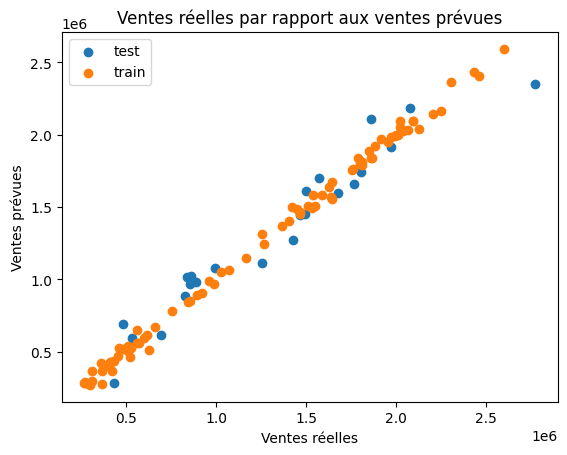

In [530]:
y_train_pred = baseline_pipeline.predict(X_train)
y_test_pred = baseline_pipeline.predict(X_test)

# visualisation des performances du mod√®le
plt.scatter(y_test, y_test_pred, label="test") 
plt.scatter(y_train, y_train_pred, label="train") 
plt.xlabel("Ventes r√©elles") 
plt.ylabel("Ventes pr√©vues") 
plt.title("Ventes r√©elles par rapport aux ventes pr√©vues")
plt.legend()
plt.show()

In [531]:
def show_feature_importance(reg_pipeline, num_cols, cat_cols, model_title):
    # Get feature names and impact coeffs
    #
    preprocessor = reg_pipeline.named_steps['preprocessing']

    # 1. Noms des features num√©riques (inchang√©s)
    num_features = num_cols

    # 2. Noms OneHotEncod√©s pour les features cat√©gorielles
    ohe = preprocessor.named_transformers_['cat'].named_steps['encoder']
    cat_feature_names = ohe.get_feature_names_out(cat_cols)

    # 3. Fusion des noms finaux
    all_feature_names = list(num_features) + list(cat_feature_names)

    regressor = reg_pipeline.named_steps['regressor']
    coefficients = regressor.coef_

    # Prepare for display
    #
    coef_df = pd.DataFrame({
        'feature': all_feature_names,
        'coefficient': coefficients
    })
    # Create a dataframe ordered by abs(coefficient)
    # limit to 40 parameters (we have a lot due to week of year feature)
    coef_df_sorted = coef_df.reindex(coef_df["coefficient"].abs().sort_values(ascending=False).index).head(40)

    # Display
    #
    plt.figure(figsize=(12, 6))
    plt.bar(coef_df_sorted['feature'], coef_df_sorted['coefficient'], color='mediumseagreen')
    plt.ylabel("coefficient")
    plt.title(f"Importance des variables ({model_title})")
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    

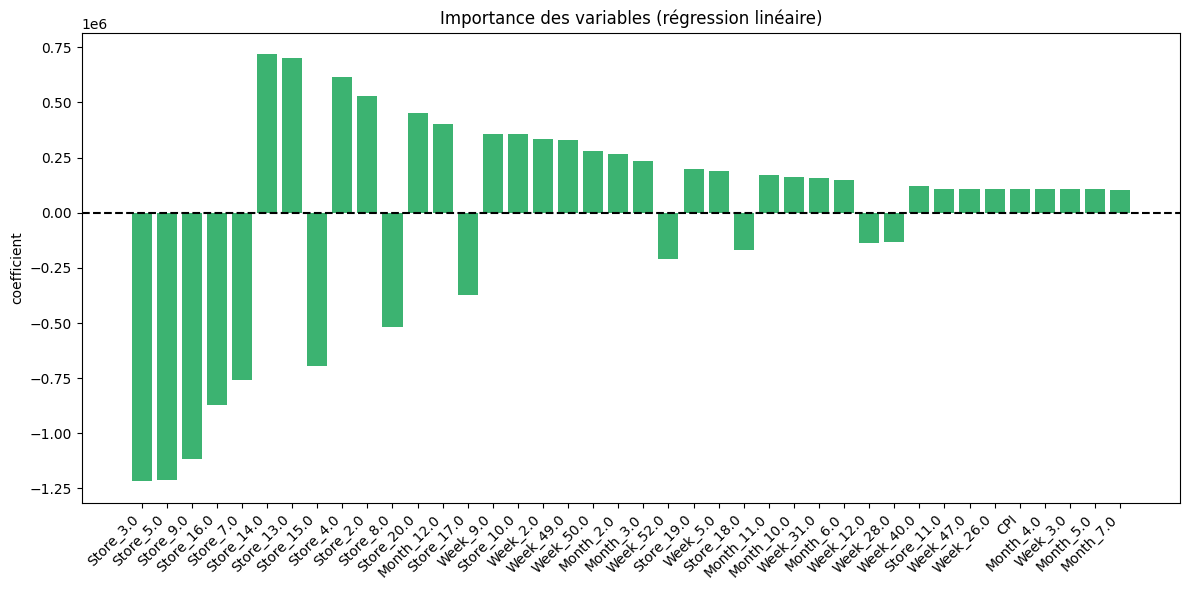

In [532]:
show_feature_importance(baseline_pipeline, numerical_features, categorical_features, "r√©gression lin√©aire")

- Le Store (ID du magasin) a un fort impact
- Ensuite on d√©c√®le les mois et semaines les plus associ√©s √† des phases cycliques
- Puis CPI (par ailleurs corr√©l√© au magasin)

## Part 3 : Limiter l'impact du surapprentissage

- Ridge
- Lasso

### Ridge

In [533]:
# Valeurs de alpha √† tester (force de r√©gularisation)
# alphas = np.logspace(-3, 3, 50)
# after first trials it was around 0.050, let refine
alphas = [0.047, 0.048, 0.049, 0.050, 0.051, 0.052, 0.053, 0.1]

# Ridge avec validation crois√©e int√©gr√©e
ridge_model = RidgeCV(alphas=alphas, cv=5)
ridge_pipeline = Pipeline(steps=[
    ('preprocessing', col_preprocessor),
    ('regressor', ridge_model)
])
ridge_pipeline.fit(X_train, y_train)

print("Alpha: ", ridge_pipeline["regressor"].alpha_)

ridge_pipeline

Alpha:  0.048


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CPI', 'Temperature',
                                                   'Unemployment',
                                                   'Fuel_Price']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Store', 'Holiday_Flag',
                                                   'Month', 'Week'])])),
                ('regressor',
                 RidgeCV(alphas=[0.047, 0.048, 0.049, 0.05, 0.051, 0.052, 0.053,
                                 0.1],
                         cv=5))])

In [534]:
ridge_metrics = evaluate(ridge_pipeline, "Ridge", X_train, X_test, y_train, y_test)

                                                            
üìà Ridge:
Train - R¬≤   : 0.9965
Train - RMSE : 40912.6467
Test - R¬≤    : 0.9272
Test - RMSE  : 157254.5549


/home/vscode/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



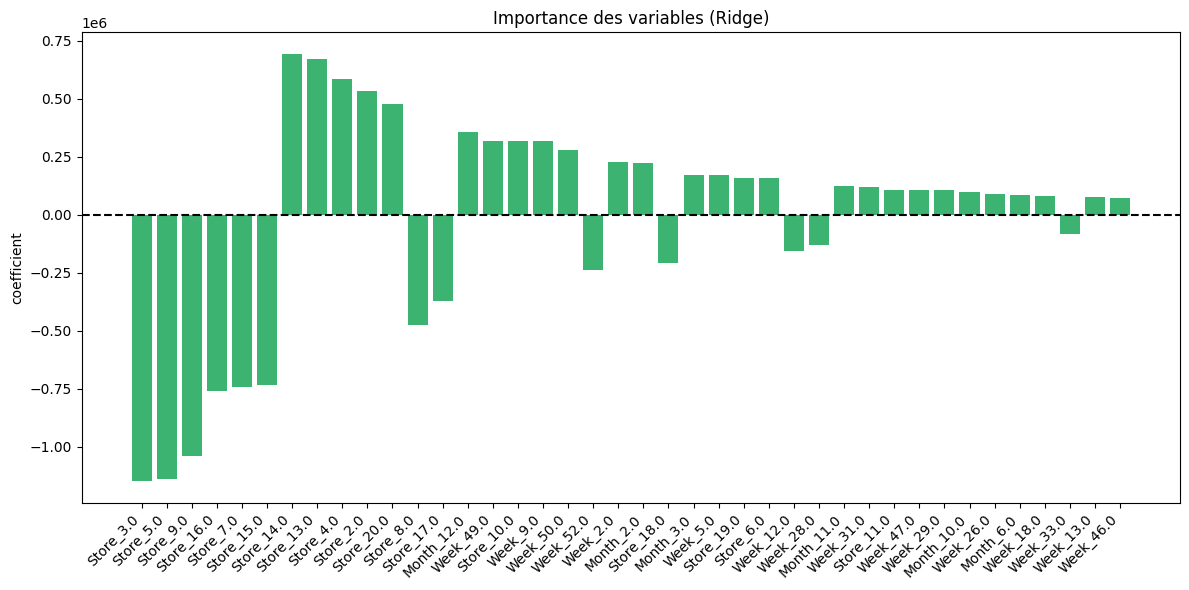

In [542]:
show_feature_importance(ridge_pipeline, numerical_features, categorical_features, "Ridge")

### Lasso

In [536]:
# Lasso avec validation crois√©e int√©gr√©e
alphas = [0.001, 0.01, 0.1, 1, 2, 5, 100, 200, 500, 1000, 2000, 5000, 10000]

lasso_model = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso_pipeline = Pipeline(steps=[
    ('preprocessing', col_preprocessor),
    ('regressor', lasso_model)
])
lasso_pipeline.fit(X_train, y_train)

print("Alpha: ", lasso_pipeline["regressor"].alpha_)

lasso_pipeline

Alpha:  1000.0


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CPI', 'Temperature',
                                                   'Unemployment',
                                                   'Fuel_Price']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Store', 'Holiday_Flag',
                                                   'Month', 'Week'])])),
                ('regressor',
                 LassoCV(alphas=[0.001, 0.01, 0.1, 1, 2, 5, 100, 200, 500, 1000,
                                 2000, 5000, 10000],
                         cv=5, max_iter=10000))])

In [537]:
lasso_metrics = evaluate(lasso_pipeline, "Lasso", X_train, X_test, y_train, y_test)


                                                            
üìà Lasso:
Train - R¬≤   : 0.9919
Train - RMSE : 62227.8200
Test - R¬≤    : 0.9523
Test - RMSE  : 127317.2292


/home/vscode/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



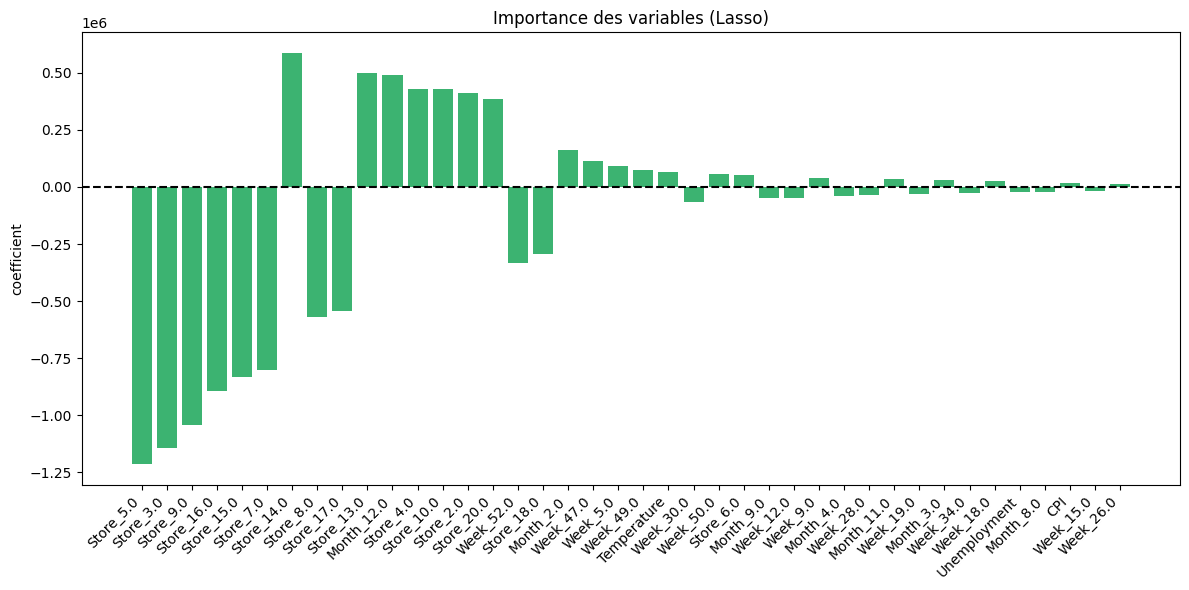

In [541]:
show_feature_importance(lasso_pipeline, numerical_features, categorical_features, "Lasso")

Lasso permet de confirmer l'impact des magasins sur la prediction!


## Conclusion

In [539]:
baseline_metrics["model"] = "Lin√©aire"
ridge_metrics["model"] = "Ridge"
lasso_metrics["model"] = "Lasso"

metrics_df = pd.DataFrame([baseline_metrics, ridge_metrics, lasso_metrics])
metrics_df.sort_values("test_r2_score", ascending=False)


train_r2_score    train_rmse  test_r2_score      test_rmse     model
2        0.991919  62227.819974       0.952252  127317.229170     Lasso
0        0.997046  37626.232374       0.933677  150051.523423  Lin√©aire
1        0.996507  40912.646705       0.927157  157254.554932     Ridge

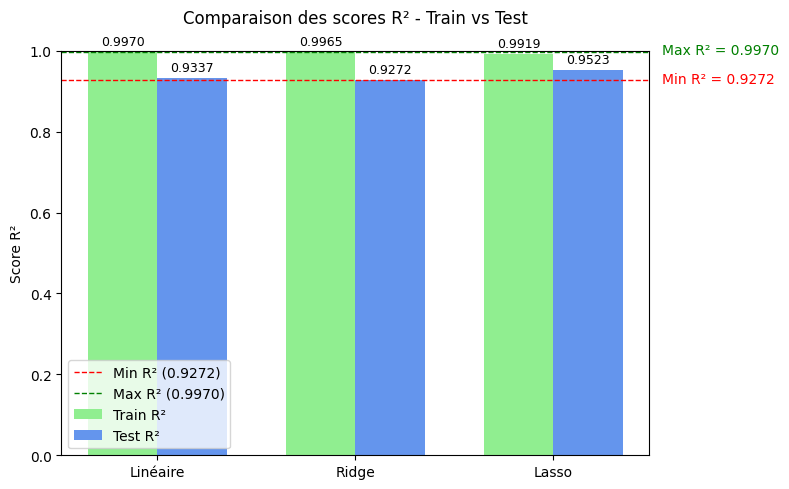

In [540]:
# Valeurs √† adapter selon tes r√©sultats r√©els
models = ["Lin√©aire", "Ridge", "Lasso"]
train_r2_values = metrics_df["train_r2_score"].values.tolist()
test_r2_values = metrics_df["test_r2_score"].values.tolist()

x = np.arange(len(models))
width = 0.35

# D√©finir les min / max pour les lignes horizontales
r2_all = train_r2_values + test_r2_values
r2_min = min(r2_all)
r2_max = max(r2_all)

fig, ax = plt.subplots(figsize=(8, 5))

# Barres train / test
bars1 = ax.bar(x - width/2, train_r2_values, width, label='Train R¬≤', color='lightgreen')
bars2 = ax.bar(x + width/2, test_r2_values, width, label='Test R¬≤', color='cornflowerblue')

# Lignes horizontales min/max
ax.axhline(r2_min, color='red', linestyle='--', linewidth=1, label=f'Min R¬≤ ({r2_min:.4f})')
ax.axhline(r2_max, color='green', linestyle='--', linewidth=1, label=f'Max R¬≤ ({r2_max:.4f})')

# Annotation des lignes √† droite
x_text = len(models) - 0.45  # position horizontale (l√©g√®rement √† droite)

ax.text(x_text, r2_min - 0.006, f"Min R¬≤ = {r2_min:.4f}", color='red')
ax.text(x_text, r2_max - 0.006, f"Max R¬≤ = {r2_max:.4f}", color='green')

# L√©gendes et titres
ax.set_ylabel('Score R¬≤')
ax.set_title('Comparaison des scores R¬≤ - Train vs Test', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.0)
ax.legend()

# Affichage des valeurs au-dessus des barres
for bars, values in zip([bars1, bars2], [train_r2_values, test_r2_values]):
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, val + 0.01, f"{val:.4f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

- Peu de donn√©es => pr√©dictions certainement peu g√©n√©ralisable aux futures entr√©es.
- Predictions tr√©s li√©es au magasin => ne sera probablement pas tr√©s pertinent sur un nouveau magasin. (il y a certainement besoin de donn√©es locales plus √©labor√©es: population, temps de trajet / nombre de personne, salaire moyen...)

- Les 3 mod√®les, dans le contexter de notre jeu de donn√©es, pr√©sentent de tr√®s bonnes performances sur les donn√©es d'entra√Ænement, avec des scores R¬≤ sup√©rieurs √† 0.99 (!). Cela montre qu‚Äôils capturent bien la structure sous-jacente des donn√©es.
- En test, Lasso obtient les meilleurs r√©sultats, avec un score R¬≤ de 0.95 et un RMSE de 127‚ÄØ317, inf√©rieur aux deux autres mod√®les. Il semble ce cette m√©thode parvient √† r√©duire le sur-apprentissage observ√© chez les autres, tout en maintenant une bonne pr√©cision.
- La R√©gression Lin√©aire et Ridge sont assez proches en termes de performance, mais moins bien en g√©n√©ralisation (√©cart plus marqu√© entre leurs scores d'entra√Ænement et de test).
- Dans notre cas, Lasso a permis une selection des variables plut√¥t pertinente.

